Tom Halloin <br> Springboard Data Science Career Track <br>

<h1 align="center">Capstone Project 2: Analysis of Berkshire Hathaway Shareholder Letters Using Natural Language Processing (NLP) Techniques</h1>

<h3 align='center'> Part 5: Topic Modelling</h3> <br>

This notebook tries to create a topic model visualization of Berkshire Hathaway's annual letters. Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

In [11]:
import gensim
import matplotlib.pyplot as plt
import nltk
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim
import re
import spacy
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import tqdm


Preprocessing: Loading English language Spacy model. Adding stop words that have showed up in previous iterations that are ambiguous or not helpful.

In [2]:
nlp = spacy.load('en_core_web_sm')

# Adding several stop words that showed up in original topics. Pronouns in general are not helpful and ambiguous.
nlp.Defaults.stop_words |= {'berkshire', 'berkshires', 'billion', 'million', 'that', 'they', 'this', 'which', 'what', 'year'}
stop_words = nlp.Defaults.stop_words

Loading all of the annual letters that are stored in a dictionary - cleaned from preprocessing earlier.

In [8]:
ls -lrth clean_letters/

total 6184
-rw-r--r--  1 liangkuang  staff    41K Dec 16 20:39 2018_letter.txt
-rw-r--r--  1 liangkuang  staff    51K Dec 16 20:39 2017_letter.txt
-rw-r--r--  1 liangkuang  staff    92K Dec 16 20:39 2016_letter.txt
-rw-r--r--  1 liangkuang  staff    97K Dec 16 20:39 2015_letter.txt
-rw-r--r--  1 liangkuang  staff   137K Dec 16 20:39 2014_letter.txt
-rw-r--r--  1 liangkuang  staff    76K Dec 16 20:39 2013_letter.txt
-rw-r--r--  1 liangkuang  staff    80K Dec 16 20:39 2012_letter.txt
-rw-r--r--  1 liangkuang  staff    80K Dec 16 20:39 2011_letter.txt
-rw-r--r--  1 liangkuang  staff    85K Dec 16 20:39 2010_letter.txt
-rw-r--r--  1 liangkuang  staff    64K Dec 16 20:39 2009_letter.txt
-rw-r--r--  1 liangkuang  staff    76K Dec 16 20:39 2008_letter.txt
-rw-r--r--  1 liangkuang  staff    70K Dec 16 20:39 2007_letter.txt
-rw-r--r--  1 liangkuang  staff    83K Dec 16 20:39 2006_letter.txt
-rw-r--r--  1 liangkuang  staff    77K Dec 16 20:39 2005_letter.txt
-rw-r--r--  1 liangkuang  staff    86

In [9]:
annual_letters = dict()
for year in range(1977, 2020):
    file = f'clean_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='remove') as f:
        annual_letters[str(year)] = str(f.readlines())    

Creating a list of potential topics, stored by entity. Starts with tokenizing documents, then extracting entities, removing special characters such as punctutation and the dreaded non-breaking space (nbsp). Then filtering topics to make sure topic is at least 4 characters long and not a stop word.

In [13]:
text_data = []
# Iterates through each article in the corpus.
for year in annual_letters:
    # Passes that article through the pipeline and adds to a new list.
    tokenized_letter = nlp(annual_letters[year])
    entities = [str(ent).lower() for ent in tokenized_letter.ents if ent.label_ != 'MONEY']
    ents_without_numbers = [re.sub('[,$%0-9.;&()]', '', ent) for ent in entities]
    remove_non_breaking_spaces = [re.sub('(nbsp)', '', ent) for ent in ents_without_numbers]
    potential_words = [chunk for chunk in remove_non_breaking_spaces if len(chunk) > 3]
    potential_words = [topic for topic in potential_words if topic not in stop_words]
    text_data.append(potential_words)

Creating a dictionary from the data, then convert to bag-of-words corpus using the gensim corpora package.

In [14]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

Computing coherence scores to measure quality of topics. Higher score -> more cohesive topics.

In [16]:
coherence_model_scores = []
for n in range(5, 25):
    model=gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=n, passes=25)
    coherence_model_lda = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_lda.get_coherence())

Plotting the coherence scores based on the number of topics.

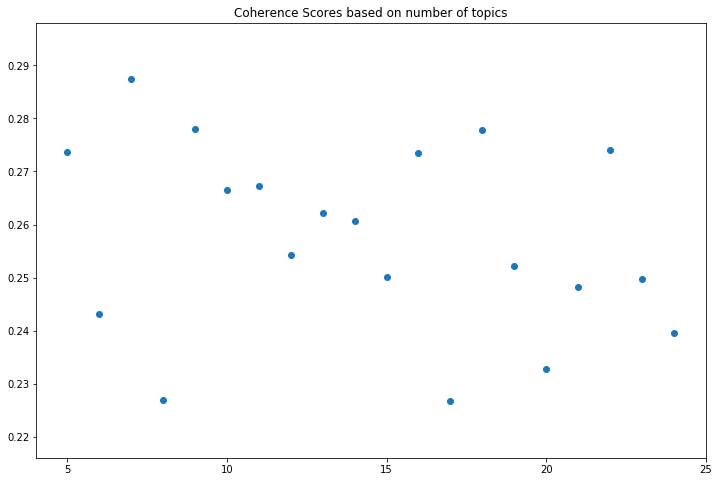

In [17]:

f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

Creating the actual topic model. Put num_topics as the value with one of the highest coherence scores, or a really low number if topics are too sparse.

In [18]:
NUM_TOPICS = coherence_model_scores.index(max(coherence_model_scores)) + 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = NUM_TOPICS)

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis


/Users/liangkuang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.011377  0.000138       1        1  32.196381
5      0.001184  0.014359       2        1  22.544245
0     -0.020292 -0.004979       3        1  18.328859
6      0.004377  0.009802       4        1  14.436601
1      0.004817  0.003580       5        1  12.067626
3      0.004160 -0.016627       6        1   0.396537
2      0.017132 -0.006273       7        1   0.029752, topic_info=     Category        Freq                     Term       Total  loglift  \
58    Default  452.000000                last year  452.000000  30.0000   
415   Default  546.000000                  charlie  546.000000  29.0000   
231   Default  366.000000                    geico  366.000000  28.0000   
8     Default  328.000000                   annual  328.000000  27.0000   
119   Default  246.000000                   about   246.000000  26.0000   
183   Default  204.000000                   second  204.000000  25.0000   
9     Default  168.000000                 annually  168.000000  24.0000   
198   Default  123.000000                this year  123.000000  23.0000   
458   Default  145.000000                   sunday  145.000000  22.0000   
200   Default  141.000000                    today  141.000000  21.0000   
1207  Default  102.000000                borsheims  102.000000  20.0000   
3145  Default   91.000000                  clayton   91.000000  19.0000   
423   Default  127.000000                     gaap  127.000000  18.0000   
452   Default  101.000000                 saturday  101.000000  17.0000   
637   Default  141.000000                    omaha  141.000000  16.0000   
2681  Default   75.000000              midamerican   75.000000  15.0000   
6     Default  119.000000                 american  119.000000  14.0000   
1778  Default   87.000000                 millions   87.000000  13.0000   
2601  Default   77.000000                  netjets   77.000000  12.0000   
278   Default   66.000000                the years   66.000000  11.0000   
351   Default   59.000000               more than    59.000000  10.0000   
109   Default   94.000000                 the year   94.000000   9.0000   
852   Default   65.000000           less than zero   65.000000   8.0000   
260   Default   84.000000             recent years   84.000000   7.0000   
393   Default   58.000000                     zero   58.000000   6.0000   
1406  Default   43.000000                 gillette   43.000000   5.0000   
564   Default   77.000000                    years   77.000000   4.0000   
3933  Default   71.000000                     bnsf   71.000000   3.0000   
634   Default   67.000000  nebraska furniture mart   67.000000   2.0000   
1000  Default   46.000000                   may th   46.000000   1.0000   
...       ...         ...                      ...         ...      ...   
58     Topic7    0.098417                last year  452.042389  -0.3123   
2662   Topic7    0.004088       financial products    7.695980   0.5797   
415    Topic7    0.101183                  charlie  546.149963  -0.4737   
452    Topic7    0.028538                 saturday  101.196533  -0.0536   
2683   Topic7    0.009904             midamericans   24.983402   0.2870   
183    Topic7    0.046383                   second  204.711655  -0.2724   
8      Topic7    0.064237                   annual  328.099426  -0.4185   
2163   Topic7    0.006690                   lloyds   15.152246   0.3947   
198    Topic7    0.030021                this year  123.594383  -0.2028   
1778   Topic7    0.022630                 millions   87.807999  -0.1436   
200    Topic7    0.031253                    today  141.724930  -0.2995   
119    Topic7    0.044779                   about   246.088577  -0.4917   
231    Topic7    0.058634                    geico  366.281403  -0.6198   
2601   Topic7    0.019994                  netjets   77.561661  -0.1434   
2724   Topic7    0.00

To compare, I am also going to use Mallet LDA. Mallet is known to provide better topics.

In [20]:

## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'mallet-2.0.8'})
## Setup mallet path change it according to your drive
mallet_path = 'mallet-2.0.8/bin/mallet'



In [21]:
coherence_model_scores = []
for n in range(5, 25):
    model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=dictionary)
    coherence_model_mallet = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_mallet.get_coherence())

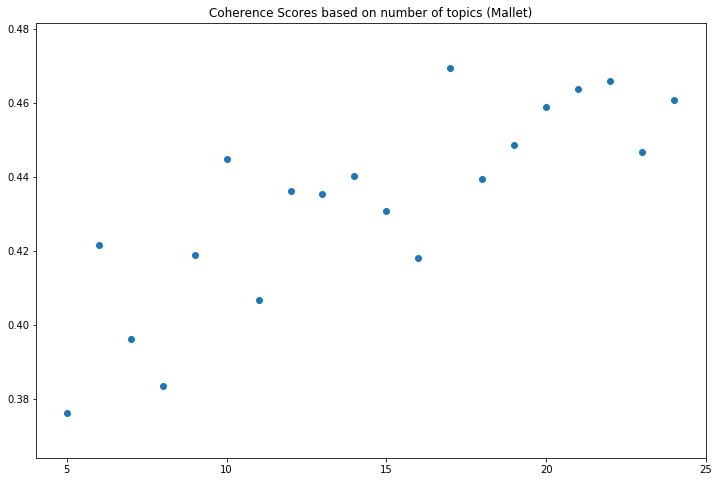

In [22]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics (Mallet)')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

In [23]:
NUM_TOPICS = 10 # After testing, this provided the "best" topics
model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Users/liangkuang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/liangkuang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/liangkuang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/liangkuang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.128689  0.240790       1        1  14.025980
8      0.164588 -0.007571       2        1  12.217716
3     -0.054231 -0.167478       3        1  11.876785
7      0.244514  0.024122       4        1  11.237863
5     -0.175390 -0.374173       5        1  11.210962
1     -0.229276  0.025331       6        1  10.269075
2      0.045696  0.107679       7        1   9.161358
6      0.258233 -0.103239       8        1   7.845081
4      0.141779  0.115385       9        1   6.867630
9     -0.267224  0.139155      10        1   5.287550, topic_info=     Category         Freq         Term        Total  loglift  logprob
392   Default  1627.000000        years  1627.000000  30.0000  30.0000
231   Default   578.000000        geico   578.000000  29.0000  29.0000
415   Default   819.000000      charlie   819.000000  28.0000  28.0000
8     Default   522.000000       annual   522.000000  27.0000  27.0000
1220  Default   327.000000      company   327.000000  26.0000  26.0000
458   Default   253.000000       sunday   253.000000  25.0000  25.0000
3145  Default   223.000000      clayton   223.000000  24.0000  24.0000
6     Default   318.000000     american   318.000000  23.0000  23.0000
2601  Default   137.000000      netjets   137.000000  22.0000  22.0000
452   Default   235.000000     saturday   235.000000  21.0000  21.0000
3362  Default   142.000000        scott   142.000000  20.0000  20.0000
3933  Default   121.000000         bnsf   121.000000  19.0000  19.0000
423   Default   206.000000         gaap   206.000000  18.0000  18.0000
637   Default   220.000000        omaha   220.000000  17.0000  17.0000
2681  Default   159.000000  midamerican   159.000000  16.0000  16.0000
1207  Default   177.000000    borsheims   177.000000  15.0000  15.0000
596   Default   138.000000    coca-cola   138.000000  14.0000  14.0000
304   Default   144.000000      america   144.000000  13.0000  13.0000
1258  Default    94.000000    insurance    94.000000  12.0000  12.0000
499   Default   134.000000       decade   134.000000  11.0000  11.0000
489   Default    87.000000      buffalo    87.000000  10.0000  10.0000
841   Default   103.000000     hathaway   103.000000   9.0000   9.0000
2223  Default   102.000000         tony   102.000000   8.0000   8.0000
9     Default   233.000000     annually   233.000000   7.0000   7.0000
525   Default    81.000000         news    81.000000   6.0000   6.0000
2856  Default   131.000000      weekend   131.000000   5.0000   5.0000
217   Default    65.000000         blue    65.000000   4.0000   4.0000
1406  Default   105.000000     gillette   105.000000   3.0000   3.0000
1194  Default   120.000000        april   120.000000   2.0000   2.0000
326   Default   142.000000      decades   142.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
238   Topic10     4.289559    homestate     4.289559   2.9398  -5.5164
167   Topic10     4.289559   midwestern     4.289559   2.9398  -5.5164
63    Topic10     3.217169   manchester     3.217169   2.9398  -5.8041
222   Topic10     3.217169    dow-jones     3.217169   2.9398  -5.8041
184   Topic10     3.217169        simon     3.217169   2.9398  -5.8041
639   Topic10     3.217169       pascal     3.217169   2.9398  -5.8041
529   Topic10    26.809741         phil    28.075255   2.8937  -3.6839
843   Topic10    24.664962     illinois    25.865320   2.8923  -3.7672
180   Topic10    12.868676     rockford    14.353642   2.8306  -4.4178
360   Topic10    15.013455    one-third    17.414171   2.7915  -4.2637
1258  Topic10    67.560547    insurance    94.335900   2.6060  -2.7596
202   Topic10    39.678417        wesco    59.900915   2.5279  -3.2918
1569  Topic10    43.967975  corporation    78.507235   2.3601  -3.1892
617   Topic10     9.651507        henry    12.679683   2.6669  -4.7055
131   Topic10    35.388858  berkshire’s    

In [24]:
# Printing the words and weights for each part of the topic model.
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.166*"charlie" + 0.074*"sunday" + 0.051*"annual" + 0.048*"company" + '
  '0.043*"american" + 0.042*"omaha" + 0.036*"tony" + 0.036*"april" + '
  '0.032*"ajit" + 0.032*"monday"'),
 (1,
  '0.046*"borsheims" + 0.045*"company" + 0.045*"coca-cola" + 0.041*"annual" + '
  '0.041*"gillette" + 0.038*"gaap" + 0.030*"usair" + 0.029*"salomon" + '
  '0.027*"coke" + 0.025*"wells"'),
 (2,
  '0.088*"years" + 0.066*"scott" + 0.047*"buffalo" + 0.044*"news" + '
  '0.041*"charlie" + 0.041*"mart" + 0.031*"nebraska" + 0.029*"omaha" + '
  '0.028*"washington" + 0.028*"annually"'),
 (3,
  '0.072*"years" + 0.051*"bnsf" + 0.046*"saturday" + 0.044*"american" + '
  '0.038*"clayton" + 0.038*"today" + 0.037*"gaap" + 0.029*"heinz" + '
  '0.028*"buffett" + 0.025*"hathaway"'),
 (4,
  '0.188*"years" + 0.064*"charlie" + 0.041*"sees" + 0.030*"graham" + '
  '0.030*"days" + 0.028*"board" + 0.025*"corporation" + 0.024*"annually" + '
  '0.024*"buffett" + 0.023*"capital"'),
 (5,
  '0.061*"netjets" + 0.058*"clayton" + 0